# Topic: Big Data Product: Violent Crime in Lockdown Britain 

## 1. Introduction

Around the entire world, lockdown policies that restrict movement and social connections were employed by national and local governments in an effort to slow the spread of COVID-19. The UK government is not an exception, having imposed a number of restrictions in England between March 2020 and May 2021. These actions included national lockdowns for extended periods of time, which were replaced by more locally-focused lockdowns in areas where the virus was extremely epidemiologically prevalent (Neanidis & Rana, 2023).

In this paper, we analyse trends in violent crime from 2010 to 2021 and investigate the impact of lockdowns on violent crime levels in Britain. 

### Scope and Plan of the study

This study has seven key steps. Firstly, we begin by loading the data and examining its structure. We then move on to data preprocessing, where we filter the data to only include violent crimes, such as both violent and sexual offenses. We also address any missing data and convert date information into a timestamp format.

The next step involves exploring the data to identify overarching trends in violent crime over time. We analyze patterns and fluctuations in crime rates to gain a comprehensive understanding of the data. Moving forward, we delve into time series analysis to assess the constancy, increase, or decrease in violent crime rates over time. We also evaluate the stationarity of the data at this stage.

A key aspect of the study involves developing a predictive model using the Random Forest Regressor model. This model helps us forecast future crime rates. We carefully compare the model's predictions with the actual data, paying special attention to verification in the context of Leicester City.

Finally, the study concludes with a detailed evaluation of the methods we used. This includes a comprehensive discussion of the advantages, disadvantages, and limitations of the techniques we utilized. Our goal is to provide a thorough assessment of the analysis conducted and offer insights into the dynamics of violent crime, contributing to a broader understanding of crime patterns.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pyspark

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, sum, col, to_date, when
from pyspark.sql import functions as F

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

At the start of this session, we ensured all requisite libraries were loaded to facilitate our analysis. We then accessed the data using Apache Spark on the Azure Infrastructure as a Service (IaaS) cloud platform. Following this, we proceeded to delve into the dataset, thoroughly exploring its structure, available columns, and the types of crimes recorded.

In [2]:
# Create a Spark session

spark_session = SparkSession.builder \
    .appName("violent_crime") \
    .getOrCreate()

from pyspark.sql.functions import col

In [3]:
pyspark.sql.SparkSession

pyspark.sql.session.SparkSession

In [4]:
spark_session

In [5]:
maindata = spark_session.read.csv("all_crimes21_hdr.txt", header = True, inferSchema=True)

## 2. Data Extraction and Filtering

In [6]:
# This block of code help us to check the information about the column names and their data types 

maindata.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [7]:
maindata.show(5)

+--------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    NULL|2010-12-01 00:00:00|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 NULL|   NULL|
|    NULL|2010-12-01 00:00:00|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 NULL|   NULL|
|    NULL|2010-12-01

In [8]:
maindata.describe().show()

+-------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+---------+---------+--------------------+---------------------+--------------------+
|summary|            Crime ID|         Reported by|        Falls within|          Longitude|          Latitude|            Location|LSOA code|LSOA name|          Crime type|Last outcome category|             Context|
+-------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+---------+---------+--------------------+---------------------+--------------------+
|  count|            40835915|            65078250|            65078250|           64120803|          64120803|            65078250| 62549985| 62549985|            65078250|             38660118|              122405|
|   mean|                NULL|                NULL|                NULL|-1.3903896490641656| 52.45883748392413|                NULL|

In [9]:
# To check for missing data and count the amount of missing values in each column


missingdata = maindata.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in maindata.columns])

# Display the count of missing values

missingdata.show()

+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category| Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|24242335|    0|          0|           0|   957447|  957447|       0|  2528265|  2528265|         0|             26418132|64955845|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+



In [12]:
# we decided to check the unique value in the list of reported location to check if there are irrelevant datas

unique_Reportedby = maindata.select('Reported by').distinct().collect()

print("Distinct values in the column:")
for row in unique_Reportedby:
    print(row['Reported by'])

Distinct values in the column:
West Mercia Police
Avon and Somerset Constabulary
Merseyside Police
Bedfordshire Police
City of London Police
Cumbria Constabulary
Durham Constabulary
Devon & Cornwall Police
Lincolnshire Police
Leicestershire Police
Staffordshire Police
British Transport Police
Dorset Police
South Yorkshire Police
West Midlands Police
Thames Valley Police
Surrey Police
Lancashire Constabulary
Humberside Police
South Wales Police
Warwickshire Police
North Yorkshire Police
Kent Police
Dyfed-Powys Police
Essex Police
Cambridgeshire Constabulary
Wiltshire Police
Norfolk Constabulary
Derbyshire Constabulary
Northamptonshire Police
Cheshire Constabulary
Hertfordshire Constabulary
Northumbria Police
Sussex Police
North Wales Police
Cleveland Police
Metropolitan Police Service
Suffolk Constabulary
Gwent Police
Gloucestershire Constabulary
Greater Manchester Police
Nottinghamshire Police
Hampshire Constabulary
West Yorkshire Police
Police Service of Northern Ireland


In [13]:
''' In this session we check if Reported by column and Falls within has the same values

After finding out that the values are the same I decided to remove one of the column, since the same location

'''

equalcolumns = maindata.filter(col('Reported by') == col('Falls within')).count()

if equalcolumns == maindata.count():
    print("Columns 'Reported by' and 'Falls within' have exactly the same values.")
else:
    print("Columns 'Reported by' and 'Falls within' do not have exactly the same values.")

Columns 'Reported by' and 'Falls within' have exactly the same values.


Our main aim of this study is to we analyse trends in violent crime from 2010 to 2021 and investigate the impact of lockdowns on violent crime levels in Britain. As part of the data extraction and filtering process we decided to first check the column information and their data type by using the printSchema() function and decided to have a quick look at the data and use the describe() function to get summary statistics for numeric columns

The information gotten made us to understand that our month column is a timestamp, logitude and latitude columns are doubles while other columns are strings. 

We also decided to check for missing values in the dataset and we found out that the Crime ID have 24242335 missing values, Logitude and Latitude have 957447 missing data, LOSA code and name have 2528265 missing data, Last outcome category have 26418132 missing data and Context have 64955845 missing data, also after comparing the datas in Reported by and Falls within, we found out that they have exactly the same data which shows the location at which a crime is reported and we decided to use the reported by column to help identify locations. 

Based on our analysis we will only be focusing on columns that are relevant which are the month, Reported by, and crime type.

In [14]:
# To select only the Month, Reported by and Crime type colum

crimedata = maindata.select("Month","Reported by","Crime type")

In [15]:
crimedata.show(5)

+-------------------+--------------------+--------------------+
|              Month|         Reported by|          Crime type|
+-------------------+--------------------+--------------------+
|2010-12-01 00:00:00|Avon and Somerset...|         Other crime|
|2010-12-01 00:00:00|Avon and Somerset...|Anti-social behav...|
|2010-12-01 00:00:00|Avon and Somerset...|Anti-social behav...|
|2010-12-01 00:00:00|Avon and Somerset...|Anti-social behav...|
|2010-12-01 00:00:00|Avon and Somerset...|Anti-social behav...|
+-------------------+--------------------+--------------------+
only showing top 5 rows



In [16]:
# To know the list of crimes on the crime data

uniquecrimedata = crimedata.select('Crime type').distinct().collect()

print("Distinct values in the column:")
for row in uniquecrimedata:
    print(row['Crime type'])

Distinct values in the column:
Other crime
Robbery
Burglary
Violent crime
Vehicle crime
Anti-social behaviour
Drugs
Public disorder and weapons
Criminal damage and arson
Shoplifting
Other theft
Bicycle theft
Public order
Theft from the person
Possession of weapons
Violence and sexual offences


Our analysis is focused on checking the trends of violent crime and its impact. Therefore, we will be filtering out crimes that are not categorized as violent crimes, including violent and sexual offenses only. 

To accomplish this, we first examined the list of crimes in our dataset and discovered that there are over 16 crime types listed. However, our focus is solely on two types of crime: violent crime and violence and sexual offenses.

In [17]:
# We decided to filter only the relevant data which are violent crime and Violence and sexual offences

violentcrimes = crimedata.filter(col('Crime type').isin('Violent crime', 'Violence and sexual offences'))

# Display the first 10 results

violentcrimes.show(10)

+-------------------+--------------------+-------------+
|              Month|         Reported by|   Crime type|
+-------------------+--------------------+-------------+
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
+-------------------+--------------------+-------------+
only showing top 10 rows



## 3. Exploratory Data Analysis

In this session, we will conduct an exploratory data analysis to help us understand the overall trends in violent crime over time. Our approach will involve visualizing the crime trends and identifying any patterns or fluctuations in the crime rate. 

To solve this problem, we will need to count the number of violent crimes that occur each month. We will then use four different visualization techniques to represent the crime trends visually.

In [18]:
''' This block of code helps use to 
    count the number of violent crime for each month 
    and filter only the Month and Count into a new variable '''

trends = violentcrimes.groupBy('Month').count().orderBy('Month')

# To Display the first 10 results

trends.show(10)

+-------------------+-----+
|              Month|count|
+-------------------+-----+
|2010-12-01 00:00:00|57580|
|2011-01-01 00:00:00|59823|
|2011-02-01 00:00:00|56691|
|2011-03-01 00:00:00|62326|
|2011-04-01 00:00:00|64299|
|2011-05-01 00:00:00|63633|
|2011-06-01 00:00:00|62475|
|2011-07-01 00:00:00|66572|
|2011-08-01 00:00:00|63284|
|2011-09-01 00:00:00|57150|
+-------------------+-----+
only showing top 10 rows



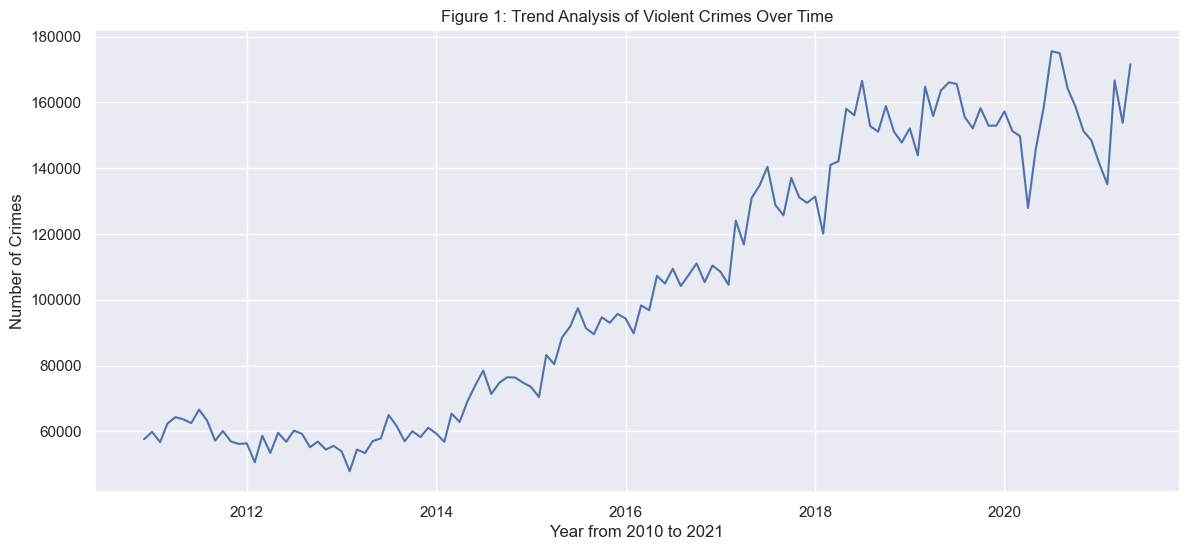

In [29]:
# First Visulaisation: Trend analysis

''' Using matplotlib.pyplot for our visualisation
    we decided to convert our spark dataframe to a pandas dataframe'''

trends_pandas = trends.toPandas()

# This bloc of code is to set up the matplotlib figure

plt.figure(figsize=(14, 6))

# Plotting the time series data

plt.plot(trends_pandas['Month'], trends_pandas['count'])
plt.title('Figure 1: Trend Analysis of Violent Crimes Over Time')
plt.xlabel('Year from 2010 to 2021')
plt.ylabel('Number of Crimes')

plt.show()

In [24]:
# Second Visualisation: Heat map

''' Before ploting the heatmap we decided to split the month column
    into Year and Month and visualise our headmap based on the volumn of 
    violent crime in each here. We decided to do it this way because of the volumn of data we have'''


# Split the 'Month' column into 'Year' and 'Month'

newtrend_data = violentcrimes.withColumn('Year', F.split('Month', '-')[0].cast('integer'))
newtrend_data = newtrend_data.withColumn('Month', F.split('Month', '-')[1].cast('integer'))

# Display the modified DataFrame

newtrend_data.show(10)

+-----+--------------------+-------------+----+
|Month|         Reported by|   Crime type|Year|
+-----+--------------------+-------------+----+
|   12|Avon and Somerset...|Violent crime|2010|
|   12|Avon and Somerset...|Violent crime|2010|
|   12|Avon and Somerset...|Violent crime|2010|
|   12|Avon and Somerset...|Violent crime|2010|
|   12|Avon and Somerset...|Violent crime|2010|
|   12|Avon and Somerset...|Violent crime|2010|
|   12|Avon and Somerset...|Violent crime|2010|
|   12|Avon and Somerset...|Violent crime|2010|
|   12|Avon and Somerset...|Violent crime|2010|
|   12|Avon and Somerset...|Violent crime|2010|
+-----+--------------------+-------------+----+
only showing top 10 rows



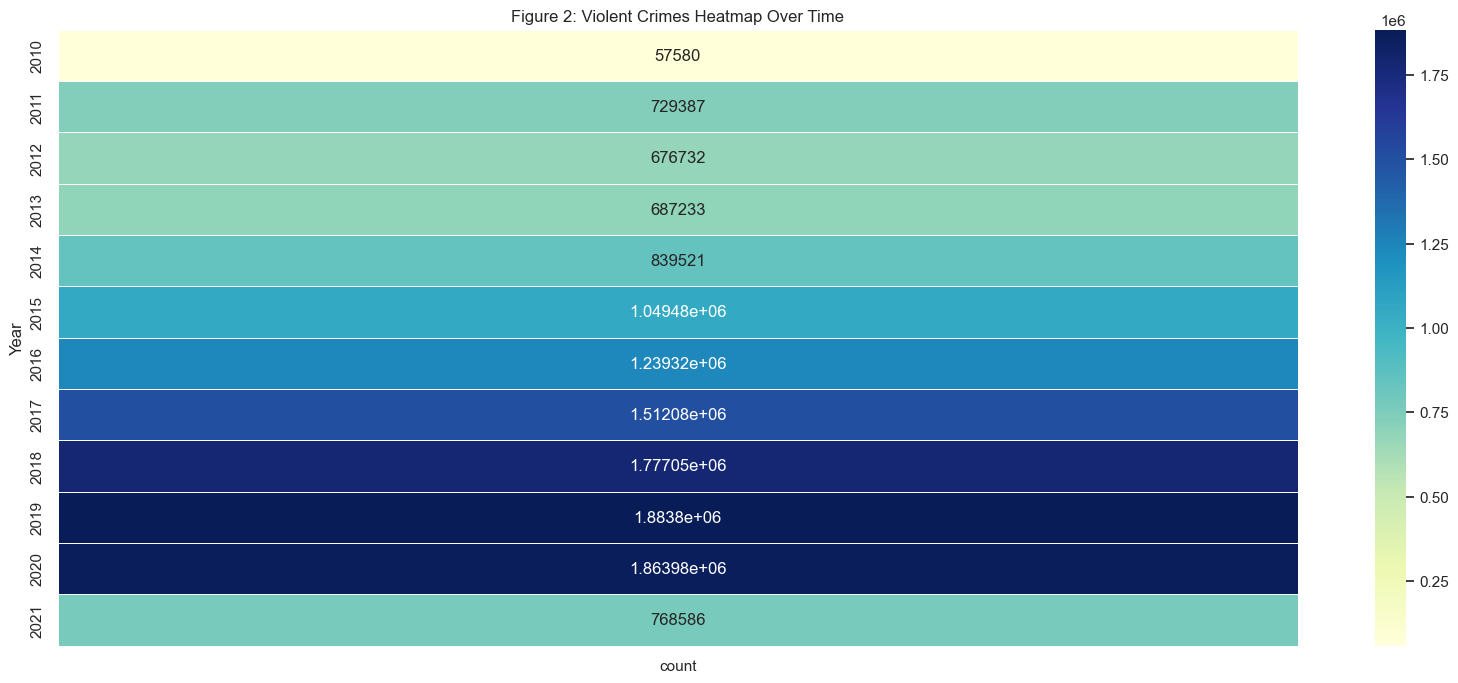

In [30]:
# Heatmap visualisation


heatmap_data = newtrend_data.groupBy('Year').count()

# This bloc of code is to set up the matplotlib figure

plt.figure(figsize=(20, 8))

# This bloc of code is to create the heatmap using Seaborn

sns.heatmap(heatmap_data.toPandas().set_index('Year'), cmap='YlGnBu', annot=True, fmt='g', linewidths=.5)

# For title 

plt.title('Figure 2: Violent Crimes Heatmap Over Time')

#To show

plt.show()

Text(0.5, 1.0, 'Figure 3: Decomposition plot of Violent Crimes Over Time')

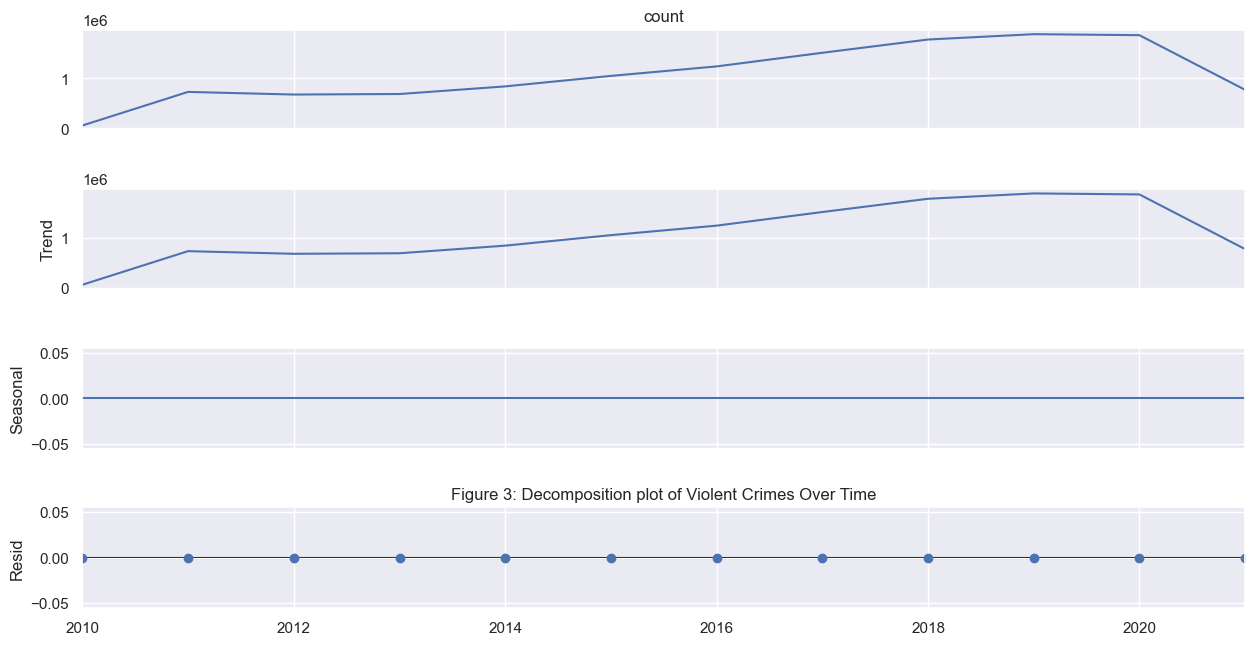

In [31]:
# Third Visualisation: Time Series Decomposition


# Group by Year and count the number of crimes

yearly_counts = newtrend_data.groupBy('Year').count().orderBy('Year')

# Explicitly select the 'Year' and 'count' columns before converting to Pandas

pandas_df = yearly_counts.select('Year', 'count').toPandas()


# Converting the 'Year' column to datetime type

pandas_df['Year'] = pd.to_datetime(pandas_df['Year'], format='%Y')

# Set the 'Year' column as the index

pandas_df = pandas_df.set_index('Year')

# Then plot for Time Series Decomposition

decomposition = sm.tsa.seasonal_decompose(pandas_df['count'], model='additive', extrapolate_trend='freq')

fig = decomposition.plot()
fig.set_size_inches(14, 7)

# For title 

plt.title('Figure 3: Decomposition plot of Violent Crimes Over Time')

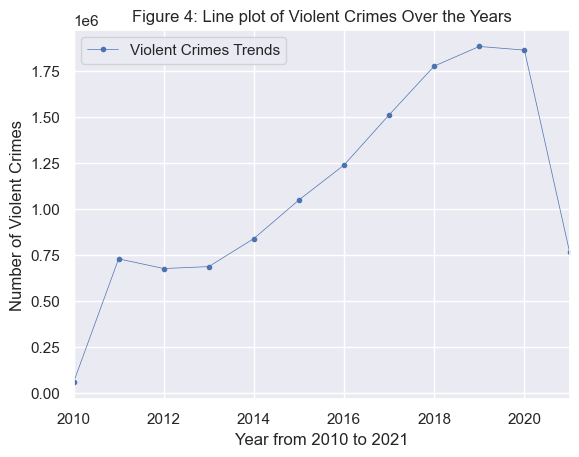

In [32]:
# Fourth Visualisation: Line plot

pandas_df.plot(y='count', marker='.', linestyle='-', linewidth=0.5,
               subplots=False,
               label='Violent Crimes Trends',
               title='Figure 4: Line plot of Violent Crimes Over the Years')
plt.ylabel('Number of Violent Crimes')
plt.xlabel('Year from 2010 to 2021')

plt.show()

As explained earlier we are are cnducting an exploratory data analysis to help us understand the overall trends in violent crime over time. Our approach will involve visualizing the crime trends and identifying any patterns or fluctuations in the crime rate.

In this study we made use of four different visualisation techniques which are Trend analysis, heatmap, decomposition plot and line plot which is labled Figure 1 to Figure 4 respectively. 

### Findings

The diagram in Figure 1 illustrates the trends in violent crime in Britain between 2010 and 2021. It shows a notable surge in violent crime from 2010 to 2011, followed by fluctuating levels in 2011. Additionally, the graph indicates a consistent increase in violent crime from 2014 to 2018, with a drop in 2018 followed by a subsequent peak, marking the highest point in the first eight years of the period. Violent crime remained elevated from 2018 to 2020, reaching its highest point over the eleven-year span.

Figures 2, 3, and 4 further support the above observations. Figure 2 highlights the initial significant peak in violent crime in 2011, while the second and highest peak occurred in 2020.

Several factors could have contributed to the peak in violent crime in early 2020. One key factor identified is the initiation of the lockdown in Britain in April 2020. It is believed that both the anticipation and enforcement of the lockdown may have influenced the spike in violent crime. Furthermore, a substantial decline in the incidence of violent crime occurred during the remaining period, likely attributed to the mandatory stay-at-home policy implemented during the lockdown.

## 4. Time Series Analysis

Testing for stationarity in time-based variables is crucial in research (Mushtaq, 2011). Moreover time series data analysis has many applications in many area but in this study we will be focusing on trends of violent crime over a period of time. Sometimes, analyzing data without applying appropriate statistical tools can lead to meaningless and misleading results, particularly when working with non-stationary variables. To avoid this, it's important to determine whether the data is stationary or non-stationary (Mushtaq, 2011). 

Various formal methods have been proposed by researchers to check the stationarity of data. However, in this article, we will focus on the test proposed by Dickey and Fuller (1979, 1981) who developed a formal test for stationarity. The significant aspect of their test was that it treated testing for non-stationarity as equivalent to testing for the presence of a unit root (Mushtaq, 2011). The augmented Dickey-Fuller (ADF) test is a commonly used statistical test to determine the presence of a unit root in a set of time series observations. The test uses the ordinary least squares (OLS) estimator, obtained by fitting the regression equation to the observed data, to make a decision about the presence of a unit root in the data generating mechanism (Paparoditis & Politis, 2016).

In [35]:
trends.show(5)

+----+------+
|Year| count|
+----+------+
|2010| 57580|
|2011|729387|
|2012|676732|
|2013|687233|
|2014|839521|
+----+------+
only showing top 5 rows

+-------------------+-----+
|              Month|count|
+-------------------+-----+
|2010-12-01 00:00:00|57580|
|2011-01-01 00:00:00|59823|
|2011-02-01 00:00:00|56691|
|2011-03-01 00:00:00|62326|
|2011-04-01 00:00:00|64299|
+-------------------+-----+
only showing top 5 rows



In [42]:
# The 'trends' is our dataframe and we will be testing the 'Count' column

timeseries_data = trends.select('Count').toPandas()['Count']

# Converting the Pandas Series into a list

timeseries_list = timeseries_data.tolist()

result = adfuller(timeseries_list)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -0.3047008618770313
p-value: 0.924835905735687
Critical Values: {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}


### Interpretation

The analysis shows that the p-value is higher than 0.05, which suggests that there is not enough evidence to reject the null hypothesis of a unit root. Also, the ADF statistic is less extreme than the critical values, which further supports that the time series data may have a unit root, indicating non-stationarity.

In conclusion, the results of the ADF test indicate that there is insufficient evidence to reject the null hypothesis of a unit root in the time series data. This suggests that there may be potential non-stationarity in the data.

## 5. Predictive Modeling for April 2020

In [43]:
trends.show(5)

+-------------------+-----+
|              Month|count|
+-------------------+-----+
|2010-12-01 00:00:00|57580|
|2011-01-01 00:00:00|59823|
|2011-02-01 00:00:00|56691|
|2011-03-01 00:00:00|62326|
|2011-04-01 00:00:00|64299|
+-------------------+-----+
only showing top 5 rows



In [44]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Feature Engineering

# Extract year and month from the "Month" column

modeldata = trends.withColumn('Year', F.year('Month'))
modeldata = modeldata.withColumn('MonthOfYear', F.month('Month'))

# Build VectorAssembler

feature_cols = ['Year', 'MonthOfYear']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
modeldata = assem bler.transform(modeldata)

modeldata.show(5)

+-------------------+-----+----+-----------+-------------+
|              Month|count|Year|MonthOfYear|     features|
+-------------------+-----+----+-----------+-------------+
|2010-12-01 00:00:00|57580|2010|         12|[2010.0,12.0]|
|2011-01-01 00:00:00|59823|2011|          1| [2011.0,1.0]|
|2011-02-01 00:00:00|56691|2011|          2| [2011.0,2.0]|
|2011-03-01 00:00:00|62326|2011|          3| [2011.0,3.0]|
|2011-04-01 00:00:00|64299|2011|          4| [2011.0,4.0]|
+-------------------+-----+----+-----------+-------------+
only showing top 5 rows



In [45]:
''' Segmenting the dataset into a training set (prior to the first lockdown) 
    and a testing set (April 2020 data)'''

trainingdata = modeldata.filter(col('Month') < '2020-04-01')
testingdata = modeldata.filter(col('Month') == '2020-04-01')

In [46]:
trainingdata.show(5)
testingdata.show()

+-------------------+-----+----+-----------+-------------+
|              Month|count|Year|MonthOfYear|     features|
+-------------------+-----+----+-----------+-------------+
|2010-12-01 00:00:00|57580|2010|         12|[2010.0,12.0]|
|2011-01-01 00:00:00|59823|2011|          1| [2011.0,1.0]|
|2011-02-01 00:00:00|56691|2011|          2| [2011.0,2.0]|
|2011-03-01 00:00:00|62326|2011|          3| [2011.0,3.0]|
|2011-04-01 00:00:00|64299|2011|          4| [2011.0,4.0]|
+-------------------+-----+----+-----------+-------------+
only showing top 5 rows

+-------------------+------+----+-----------+------------+
|              Month| count|Year|MonthOfYear|    features|
+-------------------+------+----+-----------+------------+
|2020-04-01 00:00:00|127901|2020|          4|[2020.0,4.0]|
+-------------------+------+----+-----------+------------+



In [47]:
# Building a predictive model using RandomForest Regressor

rf = RandomForestRegressor(featuresCol='features', labelCol='count')

model = rf.fit(trainingdata)

In [48]:
# Make Predictions

predictions = model.transform(testingdata)

## 6. Comparison with Actual Data:

In [49]:
# Show the predictions

predictions.select('Month', 'count', 'prediction').show()

+-------------------+------+-----------------+
|              Month| count|       prediction|
+-------------------+------+-----------------+
|2020-04-01 00:00:00|127901|147268.8363401876|
+-------------------+------+-----------------+



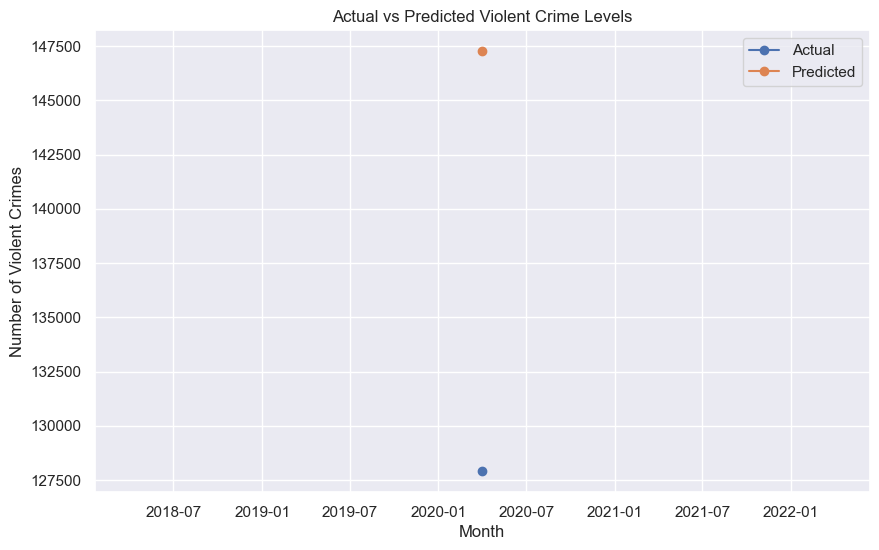

In [50]:
# Converting PySpark DataFrame to Pandas DataFrame

pandas_predictions = predictions.select('Month', 'count', 'prediction').toPandas()

# Plotting actual vs predicted crime levels

plt.figure(figsize=(10, 6))

plt.plot(pandas_predictions['Month'], pandas_predictions['count'], label='Actual', marker='o')
plt.plot(pandas_predictions['Month'], pandas_predictions['prediction'], label='Predicted', marker='o')

plt.title('Actual vs Predicted Violent Crime Levels')
plt.xlabel('Month')
plt.ylabel('Number of Violent Crimes')
plt.legend()
plt.show()

In [51]:
''' Evaluating the model's performance using mean absolute error,
    mean square error and Root mean squared error'''

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(pandas_predictions['count'], pandas_predictions['prediction'])
mse = mean_squared_error(pandas_predictions['count'], pandas_predictions['prediction'])
rmse = mean_squared_error(pandas_predictions['count'], pandas_predictions['prediction'], squared=False)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 19367.836340187612
Mean Squared Error (MSE): 375113084.5002919
Root Mean Squared Error (RMSE): 19367.836340187612


- Mean Absolute Error (MAE): On average, the difference between the predicted and actual values is about 19,367.84. This represents the model's average magnitude of error.

- Mean Squared Error (MSE): On average, the squared difference between the predicted and actual values is approximately 375,113,084.50. MSE gives more weight to large errors.

- Root Mean Squared Error (RMSE): The square root of the MSE is equal to the MAE, which is approximately 19,367.84. RMSE provides a measure of the spread of errors and is in the same unit as the target variable.

Lower values for MAE, MSE, and RMSE generally indicate better model performance. In this case, an MAE of 19,367.84 means that, on average, the model's predictions are off by this amount.

## 7. Verification for Leicester Region

In [52]:
violentcrimes.show(10)

+-------------------+--------------------+-------------+
|              Month|         Reported by|   Crime type|
+-------------------+--------------------+-------------+
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
|2010-12-01 00:00:00|Avon and Somerset...|Violent crime|
+-------------------+--------------------+-------------+
only showing top 10 rows



In [53]:
# Filter data for rows where 'Reported by' is "Leicestershire"

Leicestershire = violentcrimes.filter(col('Reported by').isin('Leicestershire Police'))

# Display the result

Leicestershire.show(5)

+-------------------+--------------------+-------------+
|              Month|         Reported by|   Crime type|
+-------------------+--------------------+-------------+
|2010-12-01 00:00:00|Leicestershire Po...|Violent crime|
|2010-12-01 00:00:00|Leicestershire Po...|Violent crime|
|2010-12-01 00:00:00|Leicestershire Po...|Violent crime|
|2010-12-01 00:00:00|Leicestershire Po...|Violent crime|
|2010-12-01 00:00:00|Leicestershire Po...|Violent crime|
+-------------------+--------------------+-------------+
only showing top 5 rows



In [54]:
# Creating a Time Series Analysis


Leicester_trends = Leicestershire.groupBy('Month').count().orderBy('Month')

# Display the result

Leicester_trends.show(5)

+-------------------+-----+
|              Month|count|
+-------------------+-----+
|2010-12-01 00:00:00| 1122|
|2011-01-01 00:00:00| 1243|
|2011-02-01 00:00:00| 1148|
|2011-03-01 00:00:00| 1246|
|2011-04-01 00:00:00| 1272|
+-------------------+-----+
only showing top 5 rows



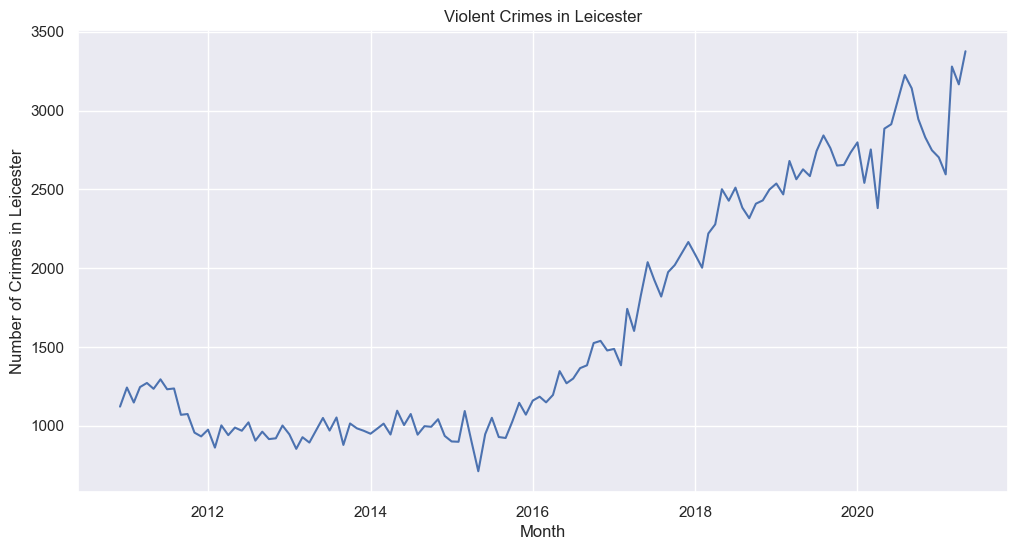

In [55]:
# Convert Spark DataFrame to Pandas DataFrame for visualization

Leicester_trends_pandas = Leicester_trends.toPandas()

# Plotting the time series data

plt.figure(figsize=(12, 6))
plt.plot(Leicester_trends_pandas['Month'], Leicester_trends_pandas['count'])
plt.title('Violent Crimes in Leicester')
plt.xlabel('Month')
plt.ylabel('Number of Crimes in Leicester')

plt.show()

In [56]:
# Split the 'Month' column into 'Year' and 'Month'

Leicestershire_violentcrime = Leicestershire.withColumn('Year', F.split('Month', '-')[0].cast('integer'))
Leicestershire_violentcrime = Leicestershire_violentcrime.withColumn('Month', F.split('Month', '-')[1].cast('integer'))

# Display the modified DataFrame

Leicestershire_violentcrime.show(10)

+-----+--------------------+-------------+----+
|Month|         Reported by|   Crime type|Year|
+-----+--------------------+-------------+----+
|   12|Leicestershire Po...|Violent crime|2010|
|   12|Leicestershire Po...|Violent crime|2010|
|   12|Leicestershire Po...|Violent crime|2010|
|   12|Leicestershire Po...|Violent crime|2010|
|   12|Leicestershire Po...|Violent crime|2010|
|   12|Leicestershire Po...|Violent crime|2010|
|   12|Leicestershire Po...|Violent crime|2010|
|   12|Leicestershire Po...|Violent crime|2010|
|   12|Leicestershire Po...|Violent crime|2010|
|   12|Leicestershire Po...|Violent crime|2010|
+-----+--------------------+-------------+----+
only showing top 10 rows



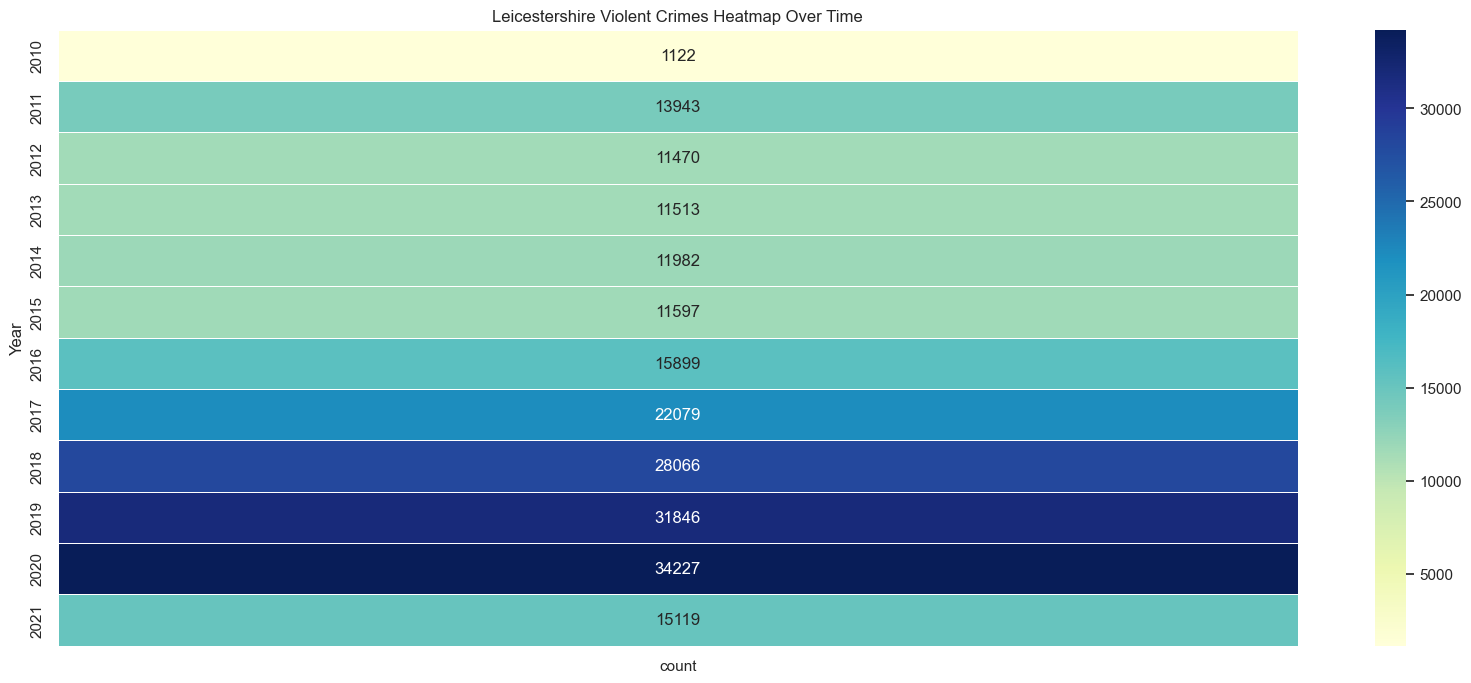

In [57]:
# Heatmap visualisation for Leicestershire region

Leicestershire_heatmap_data = Leicestershire_violentcrime.groupBy('Year').count()

# This bloc of code is to set up the matplotlib figure

plt.figure(figsize=(20, 8))

# This bloc of code is to create the heatmap using Seaborn

sns.heatmap(Leicestershire_heatmap_data.toPandas().set_index('Year'), cmap='YlGnBu', annot=True, fmt='g', linewidths=.5)

# For title 

plt.title('Leicestershire Violent Crimes Heatmap Over Time')

#To show

plt.show()

In [58]:
Leicester_trends.show(5)

+-------------------+-----+
|              Month|count|
+-------------------+-----+
|2010-12-01 00:00:00| 1122|
|2011-01-01 00:00:00| 1243|
|2011-02-01 00:00:00| 1148|
|2011-03-01 00:00:00| 1246|
|2011-04-01 00:00:00| 1272|
+-------------------+-----+
only showing top 5 rows



In [59]:
# Filter data for Leicester (prior to July 2020)

beforelockdown = Leicester_trends.filter(col('Month') < '2020-07-01')
lockdown = Leicester_trends.filter(col('Month') == '2020-07-01')
afterlockdown = Leicester_trends.filter(col('Month') > '2020-07-01')

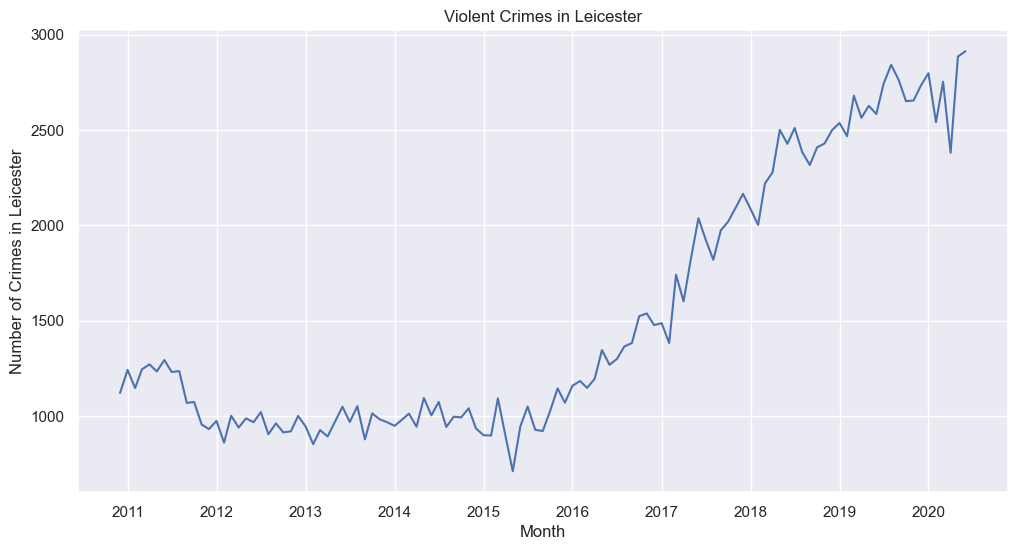

In [60]:
beforelockdown_pandas = beforelockdown.toPandas()

# Plotting the time series data

plt.figure(figsize=(12, 6))
plt.plot(beforelockdown_pandas['Month'], beforelockdown_pandas['count'])
plt.title('Violent Crimes in Leicester')
plt.xlabel('Month')
plt.ylabel('Number of Crimes in Leicester')

plt.show()

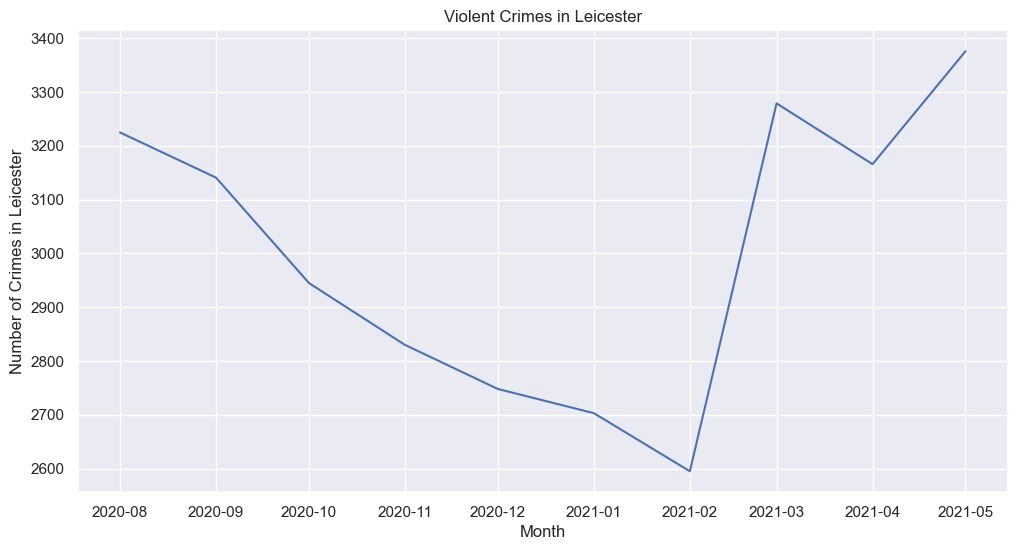

In [61]:
afterlockdown_pandas = afterlockdown.toPandas()

# Plotting the time series data

plt.figure(figsize=(12, 6))
plt.plot(afterlockdown_pandas['Month'], afterlockdown_pandas['count'])
plt.title('Violent Crimes in Leicester')
plt.xlabel('Month')
plt.ylabel('Number of Crimes in Leicester')

plt.show()

In [62]:
lockdown.show()

+-------------------+-----+
|              Month|count|
+-------------------+-----+
|2020-07-01 00:00:00| 3067|
+-------------------+-----+



### Predicting the value for the first lockdown

In [69]:
# Feature Engineering

# Extract year and month from the "Month" column

Leicestermodeldata = Leicester_trends.withColumn('Year', F.year('Month'))
Leicestermodeldata = Leicestermodeldata.withColumn('MonthOfYear', F.month('Month'))

# Build VectorAssembler

feature_cols = ['Year', 'MonthOfYear']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
Leicestermodeldata = assembler.transform(Leicestermodeldata)

Leicestermodeldata.show(5)

+-------------------+-----+----+-----------+-------------+
|              Month|count|Year|MonthOfYear|     features|
+-------------------+-----+----+-----------+-------------+
|2010-12-01 00:00:00| 1122|2010|         12|[2010.0,12.0]|
|2011-01-01 00:00:00| 1243|2011|          1| [2011.0,1.0]|
|2011-02-01 00:00:00| 1148|2011|          2| [2011.0,2.0]|
|2011-03-01 00:00:00| 1246|2011|          3| [2011.0,3.0]|
|2011-04-01 00:00:00| 1272|2011|          4| [2011.0,4.0]|
+-------------------+-----+----+-----------+-------------+
only showing top 5 rows



In [70]:
''' Also Segmenting the dataset into a training set (prior to the first lockdown) 
    and a testing set (July 2020 data)'''

Leicestertrainingdata = Leicestermodeldata.filter(col('Month') < '2020-07-01')
Leicestertestingdata = Leicestermodeldata.filter(col('Month') == '2020-07-01')

In [68]:
Leicestertrainingdata.show(5)

+-------------------+-----+----+-----------+
|              Month|count|Year|MonthOfYear|
+-------------------+-----+----+-----------+
|2010-12-01 00:00:00| 1122|2010|         12|
|2011-01-01 00:00:00| 1243|2011|          1|
|2011-02-01 00:00:00| 1148|2011|          2|
|2011-03-01 00:00:00| 1246|2011|          3|
|2011-04-01 00:00:00| 1272|2011|          4|
+-------------------+-----+----+-----------+
only showing top 5 rows



In [71]:
# Building a predictive model using RandomForest Regressor

rf = RandomForestRegressor(featuresCol='features', labelCol='count')

model_leicester = rf.fit(Leicestertrainingdata)

In [73]:
# Make Predictions

Leicester_predictions = model_leicester.transform(Leicestertestingdata)

In [74]:
# Show the predictions

Leicester_predictions.select('Month', 'count', 'prediction').show()

+-------------------+-----+------------------+
|              Month|count|        prediction|
+-------------------+-----+------------------+
|2020-07-01 00:00:00| 3067|2631.6258278388277|
+-------------------+-----+------------------+



## 8.	Evaluation and Conclusion

### Advantages:

The time series analysis and predictive modeling are robust approaches for forecasting future values based on historical data. These techniques allow you to capture patterns, trends, and seasonality in the dataset also the random Forest is a versatile algorithm that can handle both classification and regression problems. It is less prone to overfitting and provides feature importances, aiding in understanding the key drivers of predictions.

The use of metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) provides a quantitative measure of the model's performance, making it easier to assess accuracy.

### Disadvantages:

Random Forest models involve hyperparameters that require tuning for optimal performance. If not tuned correctly, the model might not capture the underlying patterns effectively, Also time series analysis often assumes that the underlying statistical properties of the data, such as mean and variance, do not change over time. Violating this assumption can impact the model's accuracy.

The analysis seems to focus on time-related features, and other potentially relevant features might not have been explored. Additional feature engineering could enhance the model's predictive power.

### Limitations

1. The predictive model's accuracy heavily relies on the quality and completeness of the historical crime data. Incomplete or inaccurate data can lead to biased predictions.

2. The model might not account for external factors that could influence crime rates, such as economic changes, social events, or policy implementations.

3. The model's generalizability to other regions might be limited. Factors affecting crime rates can vary significantly between regions, and the model's performance in one area may not apply to others.

4. While Random Forest provides predictions, it might lack the interpretability of simpler models. Understanding the specific reasons behind predictions can be challenging.

### Recommendations for Future Work:

Feature Engineering: Explore additional features that might impact crime rates, such as economic indicators, population density, or demographic information.

Fine-Tuning: Experiment with fine-tuning the Random Forest hyperparameters to improve model performance. Techniques like cross-validation can help in this process.

External Factors: Consider incorporating external factors that could influence crime rates, such as major events, economic changes, or policy implementations.

Spatial Analysis: Explore spatial patterns in crime data to understand if certain locations exhibit unique characteristics that influence crime rates.

Alternative Models: Consider trying alternative time series models or ensemble methods for comparison to evaluate whether they offer better predictive performance.

By addressing these aspects, future analyses can enhance the robustness and applicability of the predictive model.

## Reference

Mushtaq, R. (2011) ‘Augmented dickey fuller test’, SSRN Electronic Journal [Preprint]. doi:10.2139/ssrn.1911068. 

Neanidis, K.C. and Rana, M.P. (2023) ‘Crime in the era of Covid‐19: Evidence from England’, Journal of Regional Science, 63(5), pp. 1100–1130. doi:10.1111/jors.12656. 

Paparoditis, E. and Politis, D.N. (2016) ‘The asymptotic size and power of the augmented dickey–fuller test for a unit root’, Econometric Reviews, 37(9), pp. 955–973. doi:10.1080/00927872.2016.1178887. 